<a href="https://www.kaggle.com/code/awiksshiithnarang/hindi-text-generation?scriptVersionId=136791771" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Importing required libraries:**

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import tensorflow as tf
import logging

logging.getLogger( 'tensorflow' ).setLevel( logging.ERROR )

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

**Loading required datasets and preprocessing the data:**

In [2]:
def tokenize_data( corpus, num_words = -1 ):
    if num_words >= -1:
        tokenizer = tf.keras.preprocessing.text.Tokenizer( num_words = num_words )
    else:
        tokenizer = Tokenizer()
    tokenizer.fit_on_texts( corpus )
    return tokenizer

def create_corpus( dataset, field ):
    dataset[ field ] = dataset[ field ].str.replace( '[{}]'.format( string.punctuation ), '' )
    text_lines = dataset[ field ].str.cat()
    corpus = text_lines.split( '\n' )
    for i in range( len( corpus ) ):
        corpus[ i ] = corpus[ i ].rstrip()
    corpus = [ i for i in corpus if i != '' ]
    return corpus

In [3]:
dataset = pd.read_csv( '/kaggle/input/hindi-movie-reviews-dataset/train.csv', dtype = str )[ : 15 ]
corpus = create_corpus( dataset, 'text' )
tokenizer = tokenize_data( corpus, num_words = 200 )
total_words = tokenizer.num_words
print( total_words )

200


/tmp/ipykernel_3315/1968180930.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[ field ] = dataset[ field ].str.replace( '[{}]'.format( string.punctuation ), '' )


In [4]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences( [ line ] )[ 0 ]
    for i in range( 1, len( token_list ) ):
        n_gram_sequence = token_list[ : ( i + 1 ) ]
        sequences.append( n_gram_sequence )
max_sequence_len = max( [ len( seq ) for seq in sequences ] )
sequences = np.array( tf.keras.preprocessing.sequence.pad_sequences( sequences, maxlen = max_sequence_len, padding = 'pre' ) )
input_sequences, labels = sequences[ :, : -1 ], sequences[ :, -1 ]
one_hot_labels = tf.keras.utils.to_categorical( labels, num_classes = total_words )

**Building, compiling and training the model:**

In [5]:
model = tf.keras.Sequential()
model.add( tf.keras.layers.Embedding( total_words, 64, input_length = max_sequence_len - 1 ) )
model.add( tf.keras.layers.Bidirectional( tf.keras.layers.LSTM( 64 ) ) )
model.add( tf.keras.layers.Dropout( 0.5 ) )
model.add( tf.keras.layers.Dense( total_words, activation = 'relu' ) )
model.add( tf.keras.layers.Dense( total_words, activation = 'softmax' ) )
model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )

In [6]:
history = model.fit( input_sequences, one_hot_labels, epochs = 100, verbose = 1 )

Epoch 1/100
178/178 [==============================] - 22s 86ms/step - loss: 4.7091 - accuracy: 0.0536
Epoch 2/100
178/178 [==============================] - 9s 48ms/step - loss: 4.5840 - accuracy: 0.0598
Epoch 3/100
178/178 [==============================] - 8s 48ms/step - loss: 4.4582 - accuracy: 0.0821
Epoch 4/100
178/178 [==============================] - 8s 46ms/step - loss: 4.2537 - accuracy: 0.1052
Epoch 5/100
178/178 [==============================] - 9s 50ms/step - loss: 4.1147 - accuracy: 0.1166
Epoch 6/100
178/178 [==============================] - 8s 47ms/step - loss: 4.0145 - accuracy: 0.1374
Epoch 7/100
178/178 [==============================] - 8s 46ms/step - loss: 3.9517 - accuracy: 0.1308
Epoch 8/100
178/178 [==============================] - 9s 48ms/step - loss: 3.8852 - accuracy: 0.1425
Epoch 9/100
178/178 [==============================] - 8s 47ms/step - loss: 3.8345 - accuracy: 0.1549
Epoch 10/100
178/178 [==============================] - 8s 47ms/step - loss: 3.77

**Training visualization:**

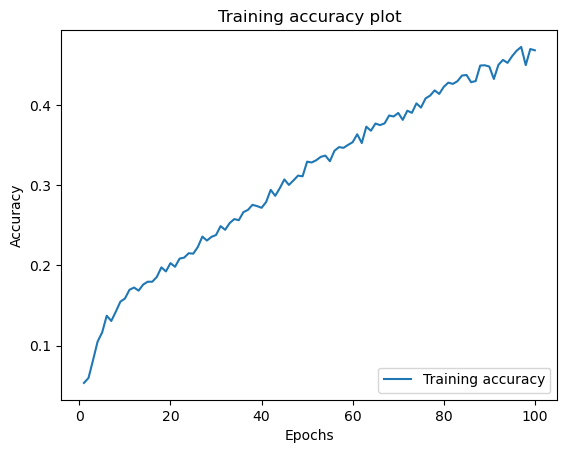

In [7]:
plt.plot( range( 1, 101 ), history.history[ 'accuracy' ], label = 'Training accuracy' )
plt.legend( loc = 'lower right' )
plt.xlabel( "Epochs" )
plt.ylabel( "Accuracy" )
plt.title( "Training accuracy plot" )
plt.show()

**Generating new text:**

In [37]:
seed_text = 'पेड़ के आगे शराबी'
next_words = 100
  
for _ in range( next_words ):
    token_list = tokenizer.texts_to_sequences( [ seed_text ] )[ 0 ]
    token_list = tf.keras.preprocessing.sequence.pad_sequences( [ token_list ], maxlen = max_sequence_len - 1, padding = 'pre' )
    predicted_probs = model.predict( token_list, verbose = 0 )[ 0 ]
    predicted = np.random.choice( [ x for x in range( len( predicted_probs ) ) ], p = predicted_probs )
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

पेड़ के आगे शराबी हैं जिसे है क्योंकि वह है कि शादी के बाद भारत की से रहे कारण यह अपने भी भारतीय शादी के साथ करते हैं कि फिल्म के नाम हैं। हालांकि वे का कर हैं। पर टीम को है। फिल्म का बात के समय फिल्म में पर रहा है। और पर उसका नहीं है और उसे ज्यादा में किया है। दोस्त भी दोनों फिर की के बीच में जाता है। से यह पूरी फिल्म की है। वे उन्होंने बेहतरीन से अच्छा है। पहले भाग में उसे उन्होंने ज्यादा ज्यादा नहीं है। तरह में क्योंकि फिल्म के बीच तो पैदा करते हैं।
